In [2]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt #繪圖用
from pyquaternion import Quaternion #用於旋轉

## 版本更新
1.修改函數名稱
2.刪除舊版函數

# PDB轉成Dataframe

In [1]:
def pdb_to_df(pdb): 
    with open(pdb,'r',) as f: #開啟檔案
        lines = []
        for line in f.readlines() :
            line = line.strip() #去除/n
            line = line.split() #以空白分割
            lines.append(line) 
    df = pd.DataFrame(lines,columns = list("abcdefghijk"),dtype=np.float64) 
    # 轉成dataframe並用abcd代替上面columns，方便取出需要之編號
    df = df.loc[:, ("c","e","g","h","i")]
    df.columns = ["element","chain", "X", "Y", "Z"]
    df.index = range(1,len(df)+1) #index改成1開始
    mask = df["element"].isin(["C","N","CA"]) #只抓取胺基酸主鍊N,CA,C
    df = df[mask] 
    df["backbone_index"] = df.index #保留原始骨架的index
    return df 

# 向量長度

In [26]:
def longth(v):
    return np.linalg.norm(v,axis=1)

# 兩向量計算夾角

二維矩陣用之dot

In [9]:
def df_dot(v1, v2): 
    return np.sum(np.multiply(v1, v2), axis=1, dtype=np.float64)

因為multply只支援同大小的array故把它變成三倍,m2.T是轉置矩陣

In [10]:
def tothree(m):
    m2 = np.array([m, m, m]) 
    return m2.T # .T表示該矩陣之轉置矩陣

### 角度
Cos = dot(v1, v2)/longth(v1)*longth(v2)
但左右之cos值相同因此無法算出正負角度

In [20]:
def angle(v1, v2, l1="check", l2="check"):
    if l1 == "check" and l2 == "check": #若l1,l2沒有值再進行運算，提高速度
        cos = df_dot(v1,v2)/(longth(v1)*longth(v2)) 
    else:
        cos = df_dot(v1,v2)/(l1*l2) 
    return np.arccos(cos)

### 向量
後項XYZ-前項XYZ

In [11]:
def df_vecter(df):
    df[["VX", "VY", "VZ"]] = df.loc[:, ("X", "Y", "Z")].diff()

### 鍵長 
$√(Vx^2+Vy^2+Vz^2)$

In [12]:
def df_bond_longth(df):
    df["bond_longth"] = longth(df.loc[:, ("VX", "VY", "VZ")].values)

### 鍵角
$(V1·V2)/(l1*l2)$

In [23]:
def df_bond_angle(df):
    df["bond_angle"] = np.NAN
    vxyz = ("VX", "VY", "VZ")
    v1 = df.loc[1:len(df)-1, vxyz].values #1-df-1
    v2 = df.loc[2:len(df), vxyz].values
    l1 = df.loc[1:len(df)-1, "bond_longth"].values
    l2 = df.loc[2:len(df), "bond_longth"].values
    df.loc[2:len(df), "bond_angle"] = angle(-v1, v2, l1, l2)

### torsion
假設有四點a-b-c-d, torsion為Vab和Vdc之夾角

In [16]:
def df_torsion(df):
    vxyz = ("VX", "VY", "VZ")
    vab = -df.loc[2:(len(df)-2), vxyz].values
    vdc = df.loc[4:len(df), vxyz].values
    vbc = -df.loc[3:(len(df)-1), vxyz].values
    lvbc = -df.loc[3:(len(df)-1), "bond_longth"].values
    vqb = vab - tothree(df_dot(vab,vbc)/(lvbc**2))*vbc
    vpc = vdc - tothree(df_dot(vdc,vbc)/(lvbc**2))*vbc
    lvqb = np.linalg.norm(vqb,axis=1)
    lvpc = np.linalg.norm(vpc,axis=1)
    phipsi = angle(vqb, vpc)
    #np.arccos(df_dot(vqb, vpc)/np.multiply(lvqb, lvpc))
    df["torsion"] = np.NaN
    df.loc[1:len(df)-3, "torsion"] = phipsi

# 分chain並進行運算

In [17]:
def group_dir(df):    
    chain_group = df.groupby("chain") #依照chain分成數個groupby
    chain_index = chain_group.size().index # [A, B, C]
    df_dir = {} #字典存放
    for i in chain_index:
        df_dir[i] = chain_group.get_group(i) # {"A"= chainA之df}
        df_dir[i].index = range(1, len(df_dir[i])+1) # reindex 方便後續處理
        operation(df_dir[i])
    return df_dir

In [28]:
def operation(df):
    df_vecter(df)
    df_bond_longth(df)
    df_bond_angle(df)
    df_torsion(df)

# 主程式
1.pdb -> df
2.分chain
3.進行運算
4.合併

In [1]:
pdb = r'C:\Users\z9875\code\skp.pdb'
df = pdb_to_df(pdb)
chain_group = df.groupby("chain") #依照chain分成數個groupby
chain_index = chain_group.size().index # [A, B, C]
df_dir = group_dir(df) 
final_df = pd.concat(df_dir)

NameError: name 'pdb_to_df' is not defined

In [30]:
final_df.head(50)

element chain       X       Y       Z  backbone_index     VX     VY  \
A 1        N     A  35.811  16.487  -8.781               1    NaN    NaN   
  2       CA     A  35.511  16.768  -7.341               2 -0.300  0.281   
  3        C     A  36.565  16.254  -6.358               3  1.054 -0.514   
  4        N     A  36.510  16.731  -5.124               6 -0.055  0.477   
  5       CA     A  37.437  16.287  -4.089               7  0.927 -0.444   
  6        C     A  37.285  14.766  -3.975               8 -0.152 -1.521   
  7        N     A  38.382  14.020  -4.022              14  1.097 -0.746   
  8       CA     A  38.495  12.650  -3.571              15  0.113 -1.370   
  9        C     A  38.830  12.538  -2.068              16  0.335 -0.112   
  10       N     A  38.205  11.591  -1.368              23 -0.625 -0.947   
  11      CA     A  38.116  11.616   0.106              24 -0.089  0.025   
  12       C     A  38.440  10.234   0.571              25  0.324 -1.382   
  13       N     A  39.203  10.207   1.659              31  0.763 -0.027   
  14      CA     A  39.482   8.982   2.355              32  0.279 -1.225   
  15       C     A  39.419   9.277   3.842              33 -0.063  0.295   
  16       N     A  39.507   8.170   4.551              36  0.088 -1.107   
  17      CA     A  39.587   8.170   5.998              37  0.080  0.000   
  18       C     A  40.833   7.404   6.503              38  1.246 -0.766   
  19       N     A  41.271   7.759   7.697              44  0.438  0.355   
  20      CA     A  42.316   7.078   8.404              45  1.045 -0.681   
  21       C     A  41.947   6.825   9.867              46 -0.369 -0.253   
  22       N     A  42.161   5.613  10.391              51  0.214 -1.212   
  23      CA     A  41.895   5.335  11.779              52 -0.266 -0.278   
  24       C     A  43.097   5.761  12.641              53  1.202  0.426   
  25       N     A  43.078   6.905  13.295              59 -0.019  1.144   
  26      CA     A  44.294   7.440  13.870              60  1.216  0.535   
  27       C     A  44.565   6.952  15.263              61  0.271 -0.488   
  28       N     A  43.588   6.232  15.791              67 -0.977 -0.720   
  29      CA     A  43.690   5.493  17.028              68  0.102 -0.739   
  30       C     A  44.196   4.099  16.745              69  0.506 -1.394   
  31       N     A  43.647   3.389  15.775              71 -0.549 -0.710   
  32      CA     A  44.184   2.069  15.468              72  0.537 -1.320   
  33       C     A  45.580   2.155  14.840              73  1.396  0.086   
  34       N     A  46.189   3.330  14.798              77  0.609  1.175   
  35      CA     A  47.421   3.465  14.044              78  1.232  0.135   
  36       C     A  48.472   3.987  14.994              79  1.051  0.522   
  37       N     A  47.994   4.633  16.037              85 -0.478  0.646   
  38      CA     A  48.936   5.280  16.893              86  0.942  0.647   
  39       C     A  49.593   4.125  17.624              87  0.657 -1.155   
  40       N     A  48.863   3.115  18.065              96 -0.730 -1.010   
  41      CA     A  49.551   1.990  18.704              97  0.688 -1.125   
  42       C     A  50.362   1.111  17.730              98  0.811 -0.879   
  43       N     A  49.828   0.860  16.547             105 -0.534 -0.251   
  44      CA     A  50.633   0.134  15.579             106  0.805 -0.726   
  45       C     A  51.947   0.920  15.357             107  1.314  0.786   
  46       N     A  51.944   2.223  15.081             114 -0.003  1.303   
  47      CA     A  53.250   2.850  14.859             115  1.306  0.627   
  48       C     A  54.131   2.952  16.143             116  0.881  0.102   
  49       N     A  53.534   3.049  17.334             121 -0.597  0.097   
  50      CA     A  54.268   2.981  18.598             122  0.734 -0.068   

         VZ  bond_longth  bond_angle   torsion  
A 1     NaN          NaN         NaN  2.881597  
  2   1.440     1.497518      

# 回推主鍊結構 
假設主練結構為 a-b-c-d 

In [60]:
def pushback(df):
    df["AnsX"], df["AnsY"], df["AnsZ"] = np.NaN, np.NaN, np.NaN #將答案三欄先設為空值
    df.loc[1:3, ("AnsX", "AnsY", "AnsZ")] = df.loc[1:3, ("X", "Y", "Z")].values 
    for i in range(4, len(df)+1):
        vba, vcb =  df.loc[i-2:i-1, ("VX", "VY", "VZ")].values #向量 vba, vcb
        axis1 = np.cross(-vba, vcb) # 第一個旋轉軸是 vab和Vcb的法向量
        anglebca = df.loc[i-1, "bond_angle"] # 角bca
        v_tmp = Quaternion(axis=axis1, angle=anglebca).rotate(-vcb) #向量Vcb以axis1為軸旋轉angle
        angle2 = df.loc[i-3, "torsion"]
        v_tmp2 = Quaternion(axis=vcb, angle=angle2).rotate(v_tmp) # V_tmp以vcb為軸旋轉angle2
        vdc = v_tmp2 * (df.loc[i, "bond_longth"]/df.loc[i-1, "bond_longth"]) # v_tmp2乘以 vbc長/vcd長
        df.loc[i:i, ("AnsX", "AnsY", "AnsZ")] =  df.loc[i-1:i-1, ("X", "Y", "Z")].values + vdc
    #df["error"] = np.sqrt(np.sum((df.loc[:, ("X","Y","Z")].values - df.loc[:, ("AnsX","AnsY","AnsZ")].values)**2, axis=1))
    df["error"] = df_longth(df.loc[:, ("X","Y","Z")].values - df.loc[:, ("AnsX","AnsY","AnsZ")].values)
    return df

In [58]:
final_df.head()

element chain       X       Y      Z  backbone_index     VX     VY     VZ  \
A 1       N     A  35.811  16.487 -8.781               1    NaN    NaN    NaN   
  2      CA     A  35.511  16.768 -7.341               2 -0.300  0.281  1.440   
  3       C     A  36.565  16.254 -6.358               3  1.054 -0.514  0.983   
  4       N     A  36.510  16.731 -5.124               6 -0.055  0.477  1.234   
  5      CA     A  37.437  16.287 -4.089               7  0.927 -0.444  1.035   

     bond_longth  bond_angle   torsion  
A 1          NaN         NaN  2.881597  
  2     1.497518         NaN  3.110461  
  3     1.530164    2.000627  1.003633  
  4     1.324126    2.036520  2.255705  
  5     1.458660    2.123758  2.822334

In [ ]:
def pushback2(df):
    df["AnsX"], df["AnsY"], df["AnsZ"] = np.NaN, np.NaN, np.NaN #將答案三欄先設為空值
    df.loc[1:3, ("AnsX", "AnsY", "AnsZ")] = df.loc[1:3, ("X", "Y", "Z")].values 
    vxyz = ("VX", "VY", "VZ")
    vba, vcb =  df.loc[2:len(df)-2, vxyz].values, df.loc[3:len(df)-3, vxyz].values

### 回推和產生答案Dataframe

In [68]:
ans_dir = {}
for i in chain_index:
    pushback(df_dir[i]) 
    ans_dir[i] = df_dir[i].loc[:, ("backbone_index","element", "X", "Y", "Z", "AnsX", "AnsY", "AnsZ", "error")]


C:\Users\z9875\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\z9875\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [69]:
ans = pd.concat(ans_dir)

In [70]:
ans.loc[:, ("AnsX", "AnsY", "AnsZ")] = ans.loc[:, ("AnsX", "AnsY", "AnsZ")].round(decimals=3)

In [71]:
ans

backbone_index element       X       Y       Z    AnsX    AnsY    AnsZ  \
A 1                 1       N  35.811  16.487  -8.781  35.811  16.487  -8.781   
  2                 2      CA  35.511  16.768  -7.341  35.511  16.768  -7.341   
  3                 3       C  36.565  16.254  -6.358  36.565  16.254  -6.358   
  4                 6       N  36.510  16.731  -5.124  36.472  16.757  -5.137   
  5                 7      CA  37.437  16.287  -4.089  37.490  16.211  -4.176   
  6                 8       C  37.285  14.766  -3.975  38.955  16.417  -4.258   
  7                14       N  38.382  14.020  -4.022  38.505  14.248  -4.048   
  8                15      CA  38.495  12.650  -3.571  38.309  12.664  -3.523   
  9                16       C  38.830  12.538  -2.068  38.176  11.393  -4.409   
  10               23       N  38.205  11.591  -1.368  38.155  11.564  -1.457   
  11               24      CA  38.116  11.616   0.106  38.798  11.197  -0.074   
  12               25       C  38.440  10.234   0.571  36.846  11.340   0.843   
  13               31       N  39.203  10.207   1.659  39.199  10.371   1.653   
  14               32      CA  39.482   8.982   2.355  39.365   8.891   2.211   
  15               33       C  39.419   9.277   3.842  40.860   8.677   2.912   
  16               36       N  39.507   8.170   4.551  39.513   8.127   4.479   
  17               37      CA  39.587   8.170   5.998  39.573   8.460   5.969   
  18               38       C  40.833   7.404   6.503  38.599   7.382   6.891   
  19               44       N  41.271   7.759   7.697  41.208   7.816   7.700   
  20               45      CA  42.316   7.078   8.404  42.324   6.947   8.233   
  21               46       C  41.947   6.825   9.867  43.481   7.784   9.099   
  22               51       N  42.161   5.613  10.391  42.220   5.570  10.242   
  23               52      CA  41.895   5.335  11.779  41.877   5.393  11.786   
  24               53       C  43.097   5.761  12.641  40.484   4.965  12.270   
  25               59       N  43.078   6.905  13.295  42.860   6.931  13.199   
  26               60      CA  44.294   7.440  13.870  44.064   7.182  14.318   
  27               61       C  44.565   6.952  15.263  45.196   8.320  13.055   
  28               67       N  43.588   6.232  15.791  43.726   6.012  15.668   
  29               68      CA  43.690   5.493  17.028  43.929   5.583  17.036   
  30               69       C  44.196   4.099  16.745  43.371   6.056  18.392   
...               ...     ...     ...     ...     ...     ...     ...     ...   
C 394            3216       N  20.931  13.540   8.442  21.165  13.684   8.428   
  395            3217      CA  20.127  12.343   8.523  20.062  12.390   8.539   
  396            3218       C  19.876  11.833   9.931  19.745  11.587   7.263   
  397            3224       N  19.987  12.691  10.947  20.006  12.748  10.893   
  398            3225      CA  19.828  12.162  12.295  19.662  12.224  12.288   
  399            3226       C  18.440  11.530  12.488  20.809  11.069  12.749   
  400            3231       N  17.414  12.235  12.013  18.109  10.761  11.452   
  401            3232      CA  16.034  11.790  12.149  16.103  11.619  12.162   
  402            3233       C  15.718  10.554  11.340  15.336  11.719  13.487   
  403            3236       N  16.214  10.432  10.122  16.683   9.653  11.358   
  404            3237      CA  15.898   9.217   9.415  15.935   9.241   9.361   
  405            3238       C  16.582   8.055  10.100  14.452   9.021   9.018   
  406            3244       N  17.769   8.292  10.658  16.623   8.286  11.412   
  407            3245      CA  18.540   7.223  11.261  18.383   7.203  11.392   
  408            3246       C  17.830   6.778  12.528  19.179   6.139  10.410   
  409            3251       N  17.399   7.717  13.367  16.536   6.634  12.254   
  410            3252      CA  16.633   7.408  14.552  16.640   7.299  14.523   
  411            3253       C  15.448 

In [27]:
final_df

element chain       X       Y       Z  backbone_index     VX     VY  \
A 1         N     A  35.811  16.487  -8.781               1    NaN    NaN   
  2        CA     A  35.511  16.768  -7.341               2 -0.300  0.281   
  3         C     A  36.565  16.254  -6.358               3  1.054 -0.514   
  4         N     A  36.510  16.731  -5.124               4 -0.055  0.477   
  5        CA     A  37.437  16.287  -4.089               5  0.927 -0.444   
  6         C     A  37.285  14.766  -3.975               6 -0.152 -1.521   
  7         N     A  38.382  14.020  -4.022               7  1.097 -0.746   
  8        CA     A  38.495  12.650  -3.571               8  0.113 -1.370   
  9         C     A  38.830  12.538  -2.068               9  0.335 -0.112   
  10        N     A  38.205  11.591  -1.368              10 -0.625 -0.947   
  11       CA     A  38.116  11.616   0.106              11 -0.089  0.025   
  12        C     A  38.440  10.234   0.571              12  0.324 -1.382   
  13        N     A  39.203  10.207   1.659              13  0.763 -0.027   
  14       CA     A  39.482   8.982   2.355              14  0.279 -1.225   
  15        C     A  39.419   9.277   3.842              15 -0.063  0.295   
  16        N     A  39.507   8.170   4.551              16  0.088 -1.107   
  17       CA     A  39.587   8.170   5.998              17  0.080  0.000   
  18        C     A  40.833   7.404   6.503              18  1.246 -0.766   
  19        N     A  41.271   7.759   7.697              19  0.438  0.355   
  20       CA     A  42.316   7.078   8.404              20  1.045 -0.681   
  21        C     A  41.947   6.825   9.867              21 -0.369 -0.253   
  22        N     A  42.161   5.613  10.391              22  0.214 -1.212   
  23       CA     A  41.895   5.335  11.779              23 -0.266 -0.278   
  24        C     A  43.097   5.761  12.641              24  1.202  0.426   
  25        N     A  43.078   6.905  13.295              25 -0.019  1.144   
  26       CA     A  44.294   7.440  13.870              26  1.216  0.535   
  27        C     A  44.565   6.952  15.263              27  0.271 -0.488   
  28        N     A  43.588   6.232  15.791              28 -0.977 -0.720   
  29       CA     A  43.690   5.493  17.028              29  0.102 -0.739   
  30        C     A  44.196   4.099  16.745              30  0.506 -1.394   
...       ...   ...     ...     ...     ...             ...    ...    ...   
C 394       N     C  20.931  13.540   8.442            1240  0.571 -1.182   
  395      CA     C  20.127  12.343   8.523            1241 -0.804 -1.197   
  396       C     C  19.876  11.833   9.931            1242 -0.251 -0.510   
  397       N     C  19.987  12.691  10.947            1243  0.111  0.858   
  398      CA     C  19.828  12.162  12.295            1244 -0.159 -0.529   
  399       C     C  18.440  11.530  12.488            1245 -1.388 -0.632   
  400       N     C  17.414  12.235  12.013            1246 -1.026  0.705   
  401      CA     C  16.034  11.790  12.149            1247 -1.380 -0.445   
  402       C     C  15.718  10.554  11.340            1248 -0.316 -1.236   
  403       N     C  16.214  10.432  10.122            1249  0.496 -0.122   
  404      CA     C  15.898   9.217   9.415            1250 -0.316 -1.215   
  405       C     C  16.582   8.055  10.100            1251  0.684 -1.162   
  406       N     C  17.769   8.292  10.658            1252  1.187  0.237   
  407      CA     C  18.540   7.223  11.261            1253  0.771 -1.069   
  408       C     C  17.830   6.778  12.528            1254 -0.710 -0.445   
  409       N     C  17.399   7.717  13.367            1255 -0.431  0.939   
  410      CA     C  16.633   7.408  14.552            1256 -0.766 -0.309   
  411       C     C  15.448   6.535  14.190            1257 -1.185 -0.873   
  412       N     C  14.724   6.906  13.135            1258 -0.724  0.371   
  413      CA     C  13.516   6.133  12.843            1259 -1.208 -0.773   
  

Text(0.5, 1.0, 'Sorted values')

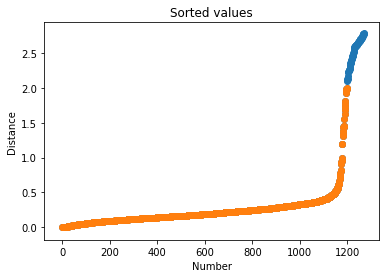

In [68]:
x = np.linspace(1, len(ans), len(ans))
y = ans.error.values

y2 = ans.error[ans.error < 2].values
x2 = np.linspace(1, len(y2), len(y2))


plt.scatter(x, y)
#plt.scatter(x[y>2], y[y>2], 'ro');

plt.scatter(x2, y2)
plt.ylabel("Distance")
plt.xlabel("Number")
plt.title("Sorted values")



Text(0.5, 1.0, 'Unsorted values')

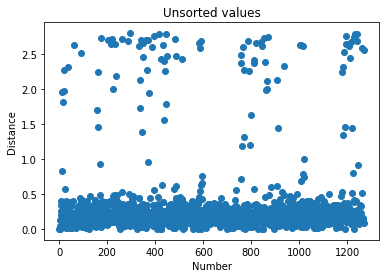

In [218]:
x = np.linspace(1, len(ans), len(ans))
y = ans.error.values

plt.scatter(x, y)

plt.xlabel("Number")
plt.ylabel("Distance")
plt.title("Unsorted values")

In [73]:
mask = ans.error > 2.0
ans[mask]

element       AnsX       AnsY       AnsZ     error
C 353      CA  29.497360  13.375929  12.580706  2.104797
  354       C  29.223344  14.698197  13.095825  2.130080
  355       N  28.110263  14.985595  13.239302  2.131650
  356      CA  28.088479  16.749628  13.570149  2.176728
  357       C  28.874914  17.651319  14.087524  2.234183
  358       N  29.398543  17.020333  15.184924  2.235674
  359      CA  30.568457  17.462719  15.684213  2.251351
  360       C  31.820578  17.811297  15.412166  2.260423
  361       N  32.151377  17.331299  14.075847  2.262257
  362      CA  33.161407  17.857962  13.408001  2.267722
  363       C  34.521077  16.939703  13.296952  2.270396
  364       N  31.579752  18.960544  12.101782  2.314765
  365      CA  31.378513  20.178357  11.156975  2.314875
  366       C  30.151047  19.651791  10.081634  2.321009
  367       N  31.712240  22.202739  11.078647  2.363034
  368      CA  31.252922  23.651998  11.857558  2.364553
  369       C  32.213054  24.405794  12.816285  2.379185
  370       N  30.263168  23.842797   9.689693  2.395146
  371      CA  29.147796  24.584428   8.866306  2.412508
  372       C  29.035223  24.115123   7.394890  2.423895
  373       N  27.533666  23.703003   7.325495  2.429578
  374      CA  27.237055  22.890787   6.057104  2.443080
  375       C  25.838176  22.213905   5.992871  2.458252
  376       N  26.064384  23.404995   4.007772  2.468442
  377      CA  24.842120  23.921446   3.297929  2.472714
  378       C  23.525063  23.386326   3.444324  2.482409
  379       N  22.598080  23.920427   3.231883  2.512849
  380      CA  21.385645  22.831865   3.085220  2.528098
  381       C  20.616796  22.054764   3.101656  2.546583
  382       N  21.758689  22.302636   1.822724  2.584763
...       ...        ...        ...        ...       ...
  394       N  21.164998  13.684499   8.427529  2.632130
  395      CA  20.062090  12.390456   8.538583  2.634045
  396       C  19.744857  11.587490   7.262549  2.640033
  397       N  20.762839  12.236125  10.843002  2.646261
  398      CA  19.662180  12.224061  12.288151  2.646362
  399       C  18.486953  11.495807  12.642844  2.650036
  400       N  17.480165  12.304125  11.983250  2.668377
  401      CA  16.102835  11.618894  12.161928  2.670427
  402       C  15.502621  10.573874  11.427399  2.675670
  403       N  16.273002  10.553743  10.141502  2.679385
  404      CA  15.935413   9.240747   9.360925  2.682928
  405       C  16.498756   7.940329   9.959545  2.684931
  406       N  17.747539   8.467991  10.597454  2.692637
  407      CA  18.383297   7.203288  11.391591  2.699523
  408       C  18.088071   6.560437  12.551033  2.702569
  409       N  17.485587   7.862891  13.217779  2.702755
  410      CA  16.640499   7.299127  14.523080  2.704899
  411       C  15.384123   6.549906  14.514869  2.707947
  412       N  14.826675   7.030905  13.120946  2.710757
  413      CA  13.647349   6.006078  12.719044  2.723434
  414       C  13.693482   4.665188  12.498155  2.724004
  415       N  15.078020   4.471524  12.211404  2.733640
  416      CA  15.381048   2.913493  12.123524  2.740340
  417       C  15.842388   2.821015  10.177258  2.752314
  418       N  16.447110   2.961589  13.717481  2.755143
  419      CA  17.215333   2.063582  14.771131  2.776997
  420       C  16.533874   1.021701  15.574370  2.778517
  421       N  17.017801  -0.122690  15.476510  2.785255
  422      CA  16.167094  -1.217099  16.153576  2.786860
  423       C  15.740272  -2.469658  15.289039  2.792510

[71 rows x 5 columns]

In [33]:
sum(ans.error)

452.96649634135593